##Modelo Principal / Main Model

In [1]:
import math
import numpy as np
import pandas as pd
from collections import Counter
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense


In [2]:
# CALCULO DE LOS BIGOTES DE UNA LISTA DE VALORES

def bigotes(xx):
    q25 = np.quantile(xx, 0.25)
    q75 = np.quantile(xx, 0.75)
    RIC = q75 - q25
    BI = q25 - 1.5*RIC
    BS = q75 + 1.5*RIC

    minimo = xx.min()
    maximo = xx.max()

    if BI < minimo:
        BI = minimo

    if BS > maximo:
        BS = maximo

    return (BI, BS)

In [3]:
# BUSCA LAS COLUMNAS QUE TIENEN UN PORCENTAJE DE VACIOS MAYOR O IGUAL A UN VALOR

def columnas_vacias(dff, porcentaje):
    L = []
    b = dff.shape[0]

    for col in dff.columns:
        a = sum(dff[col].isnull())
        r = np.round(100*a/b, 2)
        if r > porcentaje:
            L.append(col)

    return L

# columnas_vacias(40)
# columnas_vacias(df_nueva, 10)

In [4]:
# PREPARA Google Drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
# LECTURA DEL DATASET
ruta = '/gdrive/MyDrive/UNAL_Cobros.csv'
df = pd.read_csv(ruta, sep=";")

In [6]:
nbytes = os.stat(ruta).st_size
megabytes = nbytes / (1024 ** 2)
print(f"El archivo tiene {megabytes:.2f} MB")

El archivo tiene 0.98 MB


In [7]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [8]:
# INFORMACION DE LAS VARIABLES DEL DATASET
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7339 entries, 0 to 7338
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CUST_CODE           7339 non-null   float64
 1   NUMERO_FACTURA      7339 non-null   object 
 2   FECHA_ENVIO         7339 non-null   object 
 3   CANTIDAD_FACTURAS   7339 non-null   int64  
 4   FECHA_DEVOLUCION    7339 non-null   object 
 5   IMPORTE_FACTURA     7335 non-null   float64
 6   FECHA_FACTURA       7339 non-null   object 
 7   ESCENARIO_RECOBRO   7339 non-null   object 
 8   DEUDA_TOTAL         7339 non-null   float64
 9   PORTADO             7339 non-null   object 
 10  EMAIL               5144 non-null   object 
 11  EDAD                7087 non-null   object 
 12  FECHA CARGA         7339 non-null   object 
 13  IMPORTE PRODUCTO    7339 non-null   float64
 14  TARGET              7339 non-null   object 
 15  PERMANENCIA         66 non-null     object 
 16  VPT   

In [9]:
# EJEMPLO DE LOS DATOS DEL DATASET
df.head()

,CUST_CODE,NUMERO_FACTURA,FECHA_ENVIO,CANTIDAD_FACTURAS,FECHA_DEVOLUCION,IMPORTE_FACTURA,FECHA_FACTURA,ESCENARIO_RECOBRO,DEUDA_TOTAL,PORTADO,...,PERMANENCIA,VPT,FECHA_BPI,TIPO_DOCUMENTO,CODIGO_POSTAL,NUM_LINEAS_ACTIVAS,ESTADO_CLIENTE,VAP_SCF,VAP_OB,FEU
0,1.845701,A100173400951022,21/12/2022,3,25/10/2022,263.68,01/10/2022,EMP,1000.82,NO,...,NaN,S,202310.0,NaN,8029.0,12,A,N,N,N
1,1.684716,A100173428261022,23/12/2022,3,24/10/2022,3.93,01/10/2022,EMP,23.79,NO,...,NaN,N,NaN,NaN,8039.0,1,A,N,N,N
2,1.750373,A100173814331022,21/12/2022,3,30/11/2022,178.74,01/10/2022,EMP,477.83,NO,...,NaN,N,202310.0,NaN,43850.0,7,A,N,N,N
3,1.845437,A100173855691022,21/12/2022,3,26/10/2022,96.32,01/10/2022,EMP,347.94,NO,...,NaN,S,202310.0,NaN,3340.0,4,A,N,S,N
4,1.807786,A100173883841022,21/12/2022,2,25/10/2022,312.70,01/10/2022,EMP,2684.65,NO,...,NaN,N,202310.0,NaN,3007.0,4,A,N,N,N


In [10]:
# TAMAÑO DEL DATASET
print("Numero de filas: ", df.shape[0])
print("Numero de variables: ", df.shape[1])

Numero de filas:  7339
Numero de variables:  25


In [11]:
# ELIMINACION DE COLUMNAS CON INFORMACION NO RELEVANTE
df2 = df.drop(['FECHA_ENVIO', 'CUST_CODE', 'NUMERO_FACTURA',
       'FECHA_DEVOLUCION', 'FECHA_FACTURA',
       'FECHA CARGA', 'EMAIL', 'IMPORTE PRODUCTO'], axis=1)

In [12]:
# COLUMNAS RESULTANTES DESPUES DE LA ELIMINACION
df2.columns

Index(['CANTIDAD_FACTURAS', 'IMPORTE_FACTURA', 'ESCENARIO_RECOBRO',
       'DEUDA_TOTAL', 'PORTADO', 'EDAD', 'TARGET', 'PERMANENCIA', 'VPT',
       'FECHA_BPI', 'TIPO_DOCUMENTO', 'CODIGO_POSTAL', 'NUM_LINEAS_ACTIVAS',
       'ESTADO_CLIENTE', 'VAP_SCF', 'VAP_OB', 'FEU'],
      dtype='object')

In [13]:
# VARIABLE TARGET, CORRESPONDE A COBRANZA SI/NO
df2['TARGET']

0       NO
1       NO
2       SI
3       NO
4       NO
        ..
7334    NO
7335    NO
7336    NO
7337    SI
7338    SI
Name: TARGET, Length: 7339, dtype: object

In [14]:
# CAMBIAR LA VARIABLE TARGET DE TIPO CATEGORICO A NUMERICO BINARIO

df2['TARGET'] = [1 if x=='SI' else 0 for x in df2['TARGET']]

df2['TARGET'][0:5]

0    0
1    0
2    1
3    0
4    0
Name: TARGET, dtype: int64

In [15]:
df2

,CANTIDAD_FACTURAS,IMPORTE_FACTURA,ESCENARIO_RECOBRO,DEUDA_TOTAL,PORTADO,EDAD,TARGET,PERMANENCIA,VPT,FECHA_BPI,TIPO_DOCUMENTO,CODIGO_POSTAL,NUM_LINEAS_ACTIVAS,ESTADO_CLIENTE,VAP_SCF,VAP_OB,FEU
0,3,263.68,EMP,1000.82,NO,NaN,0,NaN,S,202310.0,NaN,8029.0,12,A,N,N,N
1,3,3.93,EMP,23.79,NO,NaN,0,NaN,N,NaN,NaN,8039.0,1,A,N,N,N
2,3,178.74,EMP,477.83,NO,NaN,1,NaN,N,202310.0,NaN,43850.0,7,A,N,N,N
3,3,96.32,EMP,347.94,NO,NaN,0,NaN,S,202310.0,NaN,3340.0,4,A,N,S,N
4,2,312.70,EMP,2684.65,NO,NaN,0,NaN,N,202310.0,NaN,3007.0,4,A,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,3,74.20,FU,197.20,NO,51-65,0,NaN,S,202401.0,NaN,48600.0,1,A,N,S,NaN
7335,1,95.31,FU,95.31,NO,51-65,0,NaN,N,NaN,NaN,48600.0,0,B,N,N,NaN
7336,2,55.19,PER,131.77,NO,31-50,0,NaN,N,NaN,TARJETA DE RESIDENCIA,48991.0,2,A,N,N,NaN
7337,1,93.21,FU,93.21,NO,51-65,1,NaN,S,NaN,NaN,48902.0,0,B,N,S,NaN


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7339 entries, 0 to 7338
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CANTIDAD_FACTURAS   7339 non-null   int64  
 1   IMPORTE_FACTURA     7335 non-null   float64
 2   ESCENARIO_RECOBRO   7339 non-null   object 
 3   DEUDA_TOTAL         7339 non-null   float64
 4   PORTADO             7339 non-null   object 
 5   EDAD                7087 non-null   object 
 6   TARGET              7339 non-null   int64  
 7   PERMANENCIA         66 non-null     object 
 8   VPT                 7072 non-null   object 
 9   FECHA_BPI           3168 non-null   float64
 10  TIPO_DOCUMENTO      1680 non-null   object 
 11  CODIGO_POSTAL       7306 non-null   float64
 12  NUM_LINEAS_ACTIVAS  7339 non-null   int64  
 13  ESTADO_CLIENTE      7339 non-null   object 
 14  VAP_SCF             7339 non-null   object 
 15  VAP_OB              7339 non-null   object 
 16  FEU   

In [17]:
#OBTENEMOS LOS VALORES ESTADISTICOS BASICOS DE CADA UNA DE LAS VARIABLES
df2.describe()

,CANTIDAD_FACTURAS,IMPORTE_FACTURA,DEUDA_TOTAL,TARGET,FECHA_BPI,CODIGO_POSTAL,NUM_LINEAS_ACTIVAS
count,7339.000000,7335.000000,7339.000000,7339.000000,3168.000000,7306.000000,7339.000000
mean,1.771495,139.994162,245.237291,0.256711,202348.355429,25316.665754,0.995231
std,0.816146,266.746646,381.796606,0.436848,44.494543,14350.757915,1.843674
min,1.000000,0.000000,0.000000,0.000000,202304.000000,1001.000000,0.000000
25%,1.000000,32.175000,51.670000,0.000000,202311.000000,10195.000000,0.000000
50%,2.000000,71.990000,125.610000,0.000000,202312.000000,28037.000000,1.000000
75%,2.000000,145.080000,282.535000,1.000000,202401.000000,36628.250000,1.000000
max,9.000000,5991.660000,5991.660000,1.000000,202403.000000,52006.000000,91.000000


<Axes: >

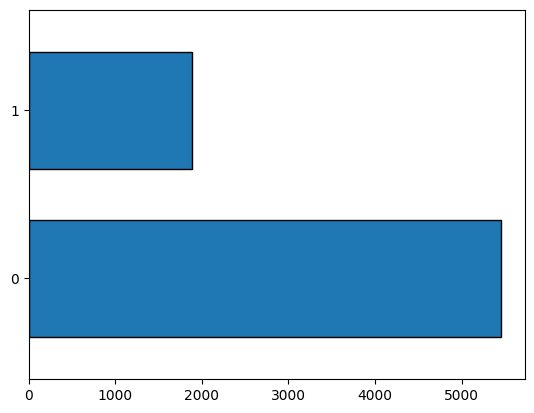

In [18]:
df2["TARGET"].value_counts().plot(kind='barh', width=0.7, edgecolor='black')

<Axes: ylabel='ESTADO_CLIENTE'>

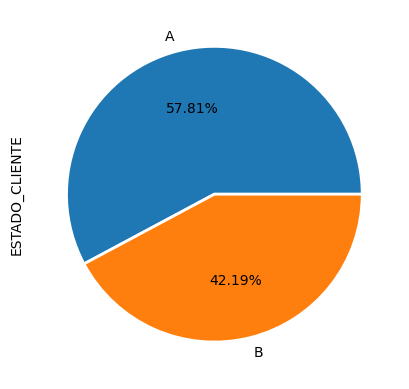

In [19]:
df2["ESTADO_CLIENTE"].value_counts().plot(kind='pie', autopct='%.2f%%', wedgeprops={"linewidth": 2, "edgecolor": "white"})

<Axes: xlabel='CANTIDAD_FACTURAS', ylabel='Count'>

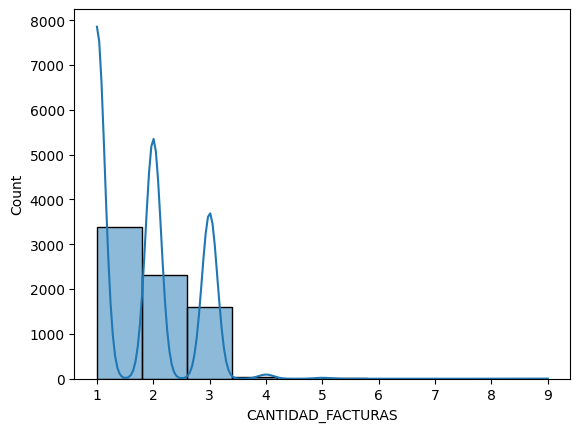

In [20]:
sns.histplot(data=df2, x="CANTIDAD_FACTURAS", bins=10, kde=True)

In [21]:
# ANALISIS DE VARIABLE PERMANENCIA
Counter(df2.PERMANENCIA)

Counter({nan: 7273,
         'Compromiso 18 meses': 58,
         'Compromiso 24 meses': 4,
         'Compromiso 12 meses': 4})

Como la variable PERMANENCIA tiene tantos valores vacios, la variable no sera usada.

In [22]:
# BORRADO DE LA VARIABLE PERMANENCIA
df2.drop("PERMANENCIA", axis=1, inplace=True)

In [23]:
# ANALISIS DE VARIABLE FEU
Counter(df2.FEU)

Counter({'N': 1169, nan: 6169, 'S': 1})

Como la variable FEU tiene tantos valores vacios, la variable no sera usada.

In [24]:
# BORRADO DE LA VARIABLE FEU
df2.drop("FEU", axis=1, inplace=True)

In [25]:
# ANALISIS DE VARIABLE TIPO_DOCUMENTO
Counter(df2.TIPO_DOCUMENTO)

Counter({nan: 5659,
         'NIF': 1294,
         'TARJETA DE RESIDENCIA': 274,
         'CIF': 78,
         'PASAPORTE': 34})

Como la variable TIPO_DOCUMENTO tiene tantos valores vacios, la variable no sera usada.

In [26]:
# BORRADO DE LA VARIABLE TIPO_DOCUMENTO
df2.drop("TIPO_DOCUMENTO", axis=1, inplace=True)

In [27]:
# ANALISIS DE VARIABLE FECHA_BPI
df2.FECHA_BPI

0       202310.0
1            NaN
2       202310.0
3       202310.0
4       202310.0
          ...   
7334    202401.0
7335         NaN
7336         NaN
7337         NaN
7338         NaN
Name: FECHA_BPI, Length: 7339, dtype: float64

En la variable FECHA_BPI los valores diferentes a NaN indican que hay fecha de baja, los valores NaN indica que no.

Por tanto crearemos una nueva variable numerica llamada BAJA así:
<br><br>
Si FECHA_BPI = NaN => BAJA=0<br>
Sino => BAJA=1

In [28]:
# CREAMOS LA VARIABLE BAJA
df2["BAJA"] = [0 if math.isnan(x) else 1 for x in df2['FECHA_BPI']]

In [29]:
df2[["FECHA_BPI","BAJA"]]

,FECHA_BPI,BAJA
0,202310.0,1
1,NaN,0
2,202310.0,1
3,202310.0,1
4,202310.0,1
...,...,...
7334,202401.0,1
7335,NaN,0
7336,NaN,0
7337,NaN,0


In [30]:
# ELIMINAMOS LA VARIABLE FECHA_BPI
df2.drop("FECHA_BPI", axis=1, inplace=True)

In [31]:
# ANALISIS DE LA VARIABLE PORTADO
Counter(df2.PORTADO)

Counter({'NO': 6512,
         'SI': 114,
         'N': 35,
         'N/A ': 379,
         'BAJAS_I ': 273,
         'BAJAS_II ': 26})

In [32]:
# AJUSTE DE LOS DATOS DE PORTADO
df2['PORTADO'] = df2['PORTADO'].map({"NO" : 0,
                                  "SI" : 1,
                                  "N" : 0,
                                  "BAJAS_I " : 0,
                                  "BAJAS_II " : 0,
                                  "N/A " : 0})

In [33]:
# PORTADO DESPUES DE LA TRANSFORMACION
Counter(df2.PORTADO)

Counter({0: 7225, 1: 114})

In [34]:
# ANALISIS DE LA VARIABLE ESCENARIO RECOBROS
Counter(df2.ESCENARIO_RECOBRO)

Counter({'EMP': 1170, 'PER': 4048, 'FU': 2121})

In [35]:
# ANALISIS DE LA VARIABLE ESCENARIO RECOBROS
def escenario(x):
  if x == "PER" or x == "FU":
    return 1
  else:
    return 0

df2["ESCENARIO_RECOBRO"]	= [escenario(x) for x in df2['ESCENARIO_RECOBRO']]

In [36]:
# ESCENARIO RECOBRO DESPUES DEL CAMBIO
Counter(df2.ESCENARIO_RECOBRO)

Counter({0: 1170, 1: 6169})

In [37]:
# ANALISIS DE LA VARIABLE ESTADO_CLIENTE
Counter(df2.ESTADO_CLIENTE)

Counter({'A': 4243, 'B': 3096})

Como la variable ESTADO_CLIENTE tiene solo dos clases usaremos el valor 1 para la clase A y el 0 para la clase B.

In [38]:
# CAMBIAR LA VARIABLE ESTADO_CLIENTE DE TIPO CATEGORICO A NUMERICO BINARIO
df2["ESTADO_CLIENTE"]	= [1 if x == "A" else 0 for x in df2['ESTADO_CLIENTE']]

In [39]:
# TRANFORMACION DE LA VARIABLE VAP_SCF CON VALORES SI Y NO A 1 Y 0
df2["VAP_SCF"]	= [0 if x == "N" else 1 for x in df2["VAP_SCF"]]

In [40]:
# TRANFORMACION DE LA VARIABLE VAP_OB CON VALORES SI Y NO A 1 Y 0
df2["VAP_OB"]	= [0 if x == "N" else 1 for x in df2["VAP_OB"]]

In [41]:
# TRANFORMACION DE LA VARIABLE VPT CON VALORES SI Y NO A 1 Y 0
df2["VPT"]	= [0 if x == "N" else 1 for x in df2["VPT"]]

In [42]:
df2

,CANTIDAD_FACTURAS,IMPORTE_FACTURA,ESCENARIO_RECOBRO,DEUDA_TOTAL,PORTADO,EDAD,TARGET,VPT,CODIGO_POSTAL,NUM_LINEAS_ACTIVAS,ESTADO_CLIENTE,VAP_SCF,VAP_OB,BAJA
0,3,263.68,0,1000.82,0,NaN,0,1,8029.0,12,1,0,0,1
1,3,3.93,0,23.79,0,NaN,0,0,8039.0,1,1,0,0,0
2,3,178.74,0,477.83,0,NaN,1,0,43850.0,7,1,0,0,1
3,3,96.32,0,347.94,0,NaN,0,1,3340.0,4,1,0,1,1
4,2,312.70,0,2684.65,0,NaN,0,0,3007.0,4,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,3,74.20,1,197.20,0,51-65,0,1,48600.0,1,1,0,1,1
7335,1,95.31,1,95.31,0,51-65,0,0,48600.0,0,0,0,0,0
7336,2,55.19,1,131.77,0,31-50,0,0,48991.0,2,1,0,0,0
7337,1,93.21,1,93.21,0,51-65,1,1,48902.0,0,0,0,1,0


In [43]:
# TRANSFORMACION DEL CODIGO_POSTAL TOMANDO SOLO EL CODIGO DE LA PROVINCIA
def cp(x):
  if x != "":
    return float(x)//1000
  else:
    return x

df2["CODIGO_POSTAL"] = [cp(x) for x in df2["CODIGO_POSTAL"]]

In [44]:
# CODIGO POSTAL TRANSFORMADO
df2["CODIGO_POSTAL"]

0        8.0
1        8.0
2       43.0
3        3.0
4        3.0
        ... 
7334    48.0
7335    48.0
7336    48.0
7337    48.0
7338    48.0
Name: CODIGO_POSTAL, Length: 7339, dtype: float64

In [45]:
# ANALISIS DE LA VARIABLE EDAD
Counter(df2.EDAD)

Counter({nan: 252, '31-50': 2205, '51-65': 3312, 'MAYOR 65': 835, '0-30': 735})

In [46]:
# IMPUTACION DEL CODIGO_POSTAL
# VAMOS A USAR LA MODA DE ESTA VARIABLE POR SER UNA PROVINCIA

df2.groupby(["CODIGO_POSTAL"])["CODIGO_POSTAL"].count().sort_values(ascending=False).head(10)

# EL VALOR DE LA MODA ES EL CODIGO 28

CODIGO_POSTAL
28.0    1076
8.0      930
46.0     421
3.0      311
41.0     301
29.0     290
35.0     245
38.0     216
11.0     201
30.0     197
Name: CODIGO_POSTAL, dtype: int64

In [47]:
# VAMOS A REMPLAZAR LOS VACIOS EN LAS PROVINCIA CON LA MODA, EL VALOR ES 28
df2["CODIGO_POSTAL"].fillna(value=28, inplace=True)

In [48]:
df2

,CANTIDAD_FACTURAS,IMPORTE_FACTURA,ESCENARIO_RECOBRO,DEUDA_TOTAL,PORTADO,EDAD,TARGET,VPT,CODIGO_POSTAL,NUM_LINEAS_ACTIVAS,ESTADO_CLIENTE,VAP_SCF,VAP_OB,BAJA
0,3,263.68,0,1000.82,0,NaN,0,1,8.0,12,1,0,0,1
1,3,3.93,0,23.79,0,NaN,0,0,8.0,1,1,0,0,0
2,3,178.74,0,477.83,0,NaN,1,0,43.0,7,1,0,0,1
3,3,96.32,0,347.94,0,NaN,0,1,3.0,4,1,0,1,1
4,2,312.70,0,2684.65,0,NaN,0,0,3.0,4,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,3,74.20,1,197.20,0,51-65,0,1,48.0,1,1,0,1,1
7335,1,95.31,1,95.31,0,51-65,0,0,48.0,0,0,0,0,0
7336,2,55.19,1,131.77,0,31-50,0,0,48.0,2,1,0,0,0
7337,1,93.21,1,93.21,0,51-65,1,1,48.0,0,0,0,1,0


In [49]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7339 entries, 0 to 7338
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CANTIDAD_FACTURAS   7339 non-null   int64  
 1   IMPORTE_FACTURA     7335 non-null   float64
 2   ESCENARIO_RECOBRO   7339 non-null   int64  
 3   DEUDA_TOTAL         7339 non-null   float64
 4   PORTADO             7339 non-null   int64  
 5   EDAD                7087 non-null   object 
 6   TARGET              7339 non-null   int64  
 7   VPT                 7339 non-null   int64  
 8   CODIGO_POSTAL       7339 non-null   float64
 9   NUM_LINEAS_ACTIVAS  7339 non-null   int64  
 10  ESTADO_CLIENTE      7339 non-null   int64  
 11  VAP_SCF             7339 non-null   int64  
 12  VAP_OB              7339 non-null   int64  
 13  BAJA                7339 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 802.8+ KB


In [50]:
# CAMBIO IMPORTE_FACTURA DE CATEGORICO A NUMERICO
df2["IMPORTE_FACTURA"] = df2["IMPORTE_FACTURA"].astype("float")

In [51]:
# IMPUTACION DE VALORES A LAS VARIABLES VACIAS

cols20 = columnas_vacias(df2, 20)
for columna in cols20:
    # print("10: ", columna)
    if df2[columna].dtype == "object":
        df2[columna].fillna(value="NO IDENTIFICADO", inplace=True)
        print(columna, " imputada con NO IDENTIFICADO por tener mas del 20% de vacios")
    else:
        mediana = df2[columna].median(skipna=True)  # numeric_onlybool
        df2[columna].fillna(value=mediana, inplace=True)
        print(columna, " imputada con la mediana por tener mas del 20% de vacios: ", mediana)


cols0 = columnas_vacias(df2, 0)
for columna in cols0:
    # print("0: ", columna)
    if df2[columna].dtype == "object":
        moda = df2[columna].mode()[0]
        df2[columna].fillna(value=moda, inplace=True)
        print(columna, " imputada con la moda por tener entre 0% y 20% de vacios: ", moda)
    else:
        mediana = df[columna].median(skipna=True)  # numeric_onlybool
        df2[columna].fillna(value=mediana, inplace=True)
        print(columna, " imputada con la mediana por tener entre 0% y 20% de vacios: ", mediana)

IMPORTE_FACTURA  imputada con la mediana por tener entre 0% y 20% de vacios:  71.99
EDAD  imputada con la moda por tener entre 0% y 20% de vacios:  51-65


In [52]:
df2

,CANTIDAD_FACTURAS,IMPORTE_FACTURA,ESCENARIO_RECOBRO,DEUDA_TOTAL,PORTADO,EDAD,TARGET,VPT,CODIGO_POSTAL,NUM_LINEAS_ACTIVAS,ESTADO_CLIENTE,VAP_SCF,VAP_OB,BAJA
0,3,263.68,0,1000.82,0,51-65,0,1,8.0,12,1,0,0,1
1,3,3.93,0,23.79,0,51-65,0,0,8.0,1,1,0,0,0
2,3,178.74,0,477.83,0,51-65,1,0,43.0,7,1,0,0,1
3,3,96.32,0,347.94,0,51-65,0,1,3.0,4,1,0,1,1
4,2,312.70,0,2684.65,0,51-65,0,0,3.0,4,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,3,74.20,1,197.20,0,51-65,0,1,48.0,1,1,0,1,1
7335,1,95.31,1,95.31,0,51-65,0,0,48.0,0,0,0,0,0
7336,2,55.19,1,131.77,0,31-50,0,0,48.0,2,1,0,0,0
7337,1,93.21,1,93.21,0,51-65,1,1,48.0,0,0,0,1,0


In [53]:
# CALCULO DE LOS BIGOTES PARA VARIABLES

lista_numericas = ["CANTIDAD_FACTURAS", "IMPORTE_FACTURA", "DEUDA_TOTAL", "NUM_LINEAS_ACTIVAS"]

for columna in lista_numericas:
    BI, BS = bigotes(df2[columna])
    print("{}: {:,.2f}, {:,.2f}".format(columna, BI, BS))

CANTIDAD_FACTURAS: 1.00, 3.50
IMPORTE_FACTURA: 0.00, 314.24
DEUDA_TOTAL: 0.00, 628.83
NUM_LINEAS_ACTIVAS: 0.00, 2.50


In [54]:
# AJUSTE DE CANTIDAD_FACTURAS SEGUN EL BIGOTE
df2['CANTIDAD_FACTURAS'] = [1   if x < 1   else x for x in df2['CANTIDAD_FACTURAS']]
df2['CANTIDAD_FACTURAS'] = [3.5 if x > 3.5 else x for x in df2['CANTIDAD_FACTURAS']]

In [55]:
# AJUSTE DE IMPORTE_FACTURA SEGUN EL BIGOTE
df2['IMPORTE_FACTURA'] = [0      if x < 0      else x for x in df2['IMPORTE_FACTURA']]
df2['IMPORTE_FACTURA'] = [314.24 if x > 314.24 else x for x in df2['IMPORTE_FACTURA']]

In [56]:
# AJUSTE DE IMPORTE_FACTURA SEGUN EL BIGOTE
df2['DEUDA_TOTAL'] = [0      if x < 0      else x for x in df2['DEUDA_TOTAL']]
df2['DEUDA_TOTAL'] = [628.83 if x > 628.83 else x for x in df2['DEUDA_TOTAL']]

In [57]:
# AJUSTE DE IMPORTE_FACTURA SEGUN EL BIGOTE
df2['NUM_LINEAS_ACTIVAS'] = [0   if x < 0   else x for x in df2['NUM_LINEAS_ACTIVAS']]
df2['NUM_LINEAS_ACTIVAS'] = [2.5 if x > 2.5 else x for x in df2['NUM_LINEAS_ACTIVAS']]

In [58]:
df2["EDAD"]

0       51-65
1       51-65
2       51-65
3       51-65
4       51-65
        ...  
7334    51-65
7335    51-65
7336    31-50
7337    51-65
7338    51-65
Name: EDAD, Length: 7339, dtype: object

In [59]:
# CREACION DE VARIABLES DUMMIES PARA LA EDAD
modelo_dummy = OneHotEncoder(sparse=False)
df2_dummy = modelo_dummy.fit_transform(pd.DataFrame(df2["EDAD"]))
df2_dummy = pd.DataFrame(df2_dummy, columns=["0_30", "31_50", "51_65", "MAYOR_65"])
df2_dummy

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0_30,31_50,51_65,MAYOR_65
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
7334,0.0,0.0,1.0,0.0
7335,0.0,0.0,1.0,0.0
7336,0.0,1.0,0.0,0.0
7337,0.0,0.0,1.0,0.0


In [60]:
# CONCATENA DATASET NUMERICO CON EL DATASET DE DUMMIES DE LA EDAD
df3 = pd.concat([df2, df2_dummy], axis=1)
df3.sample(20)

# ELIMINA LA VARIABLE EDAD
df3.drop("EDAD", axis=1, inplace=True)

<ipython-input-61-bc20b70975c1>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df3[["CANTIDAD_FACTURAS", "IMPORTE_FACTURA", "DEUDA_TOTAL", "NUM_LINEAS_ACTIVAS"]].hist(ax = axes);


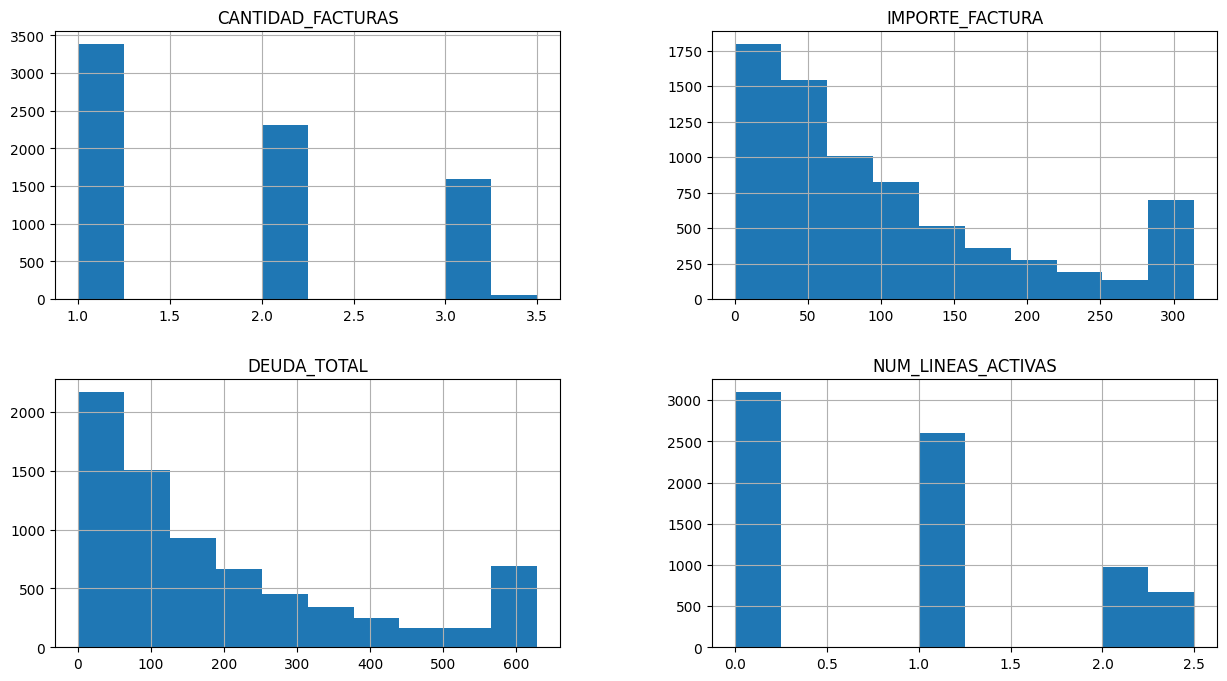

In [61]:
# DISTRIBUCIÓN DE LOS DATOS (HISTOGRAMAS)
fig = plt.figure(figsize = (15,8))
axes = fig.gca()
df3[["CANTIDAD_FACTURAS", "IMPORTE_FACTURA", "DEUDA_TOTAL", "NUM_LINEAS_ACTIVAS"]].hist(ax = axes);

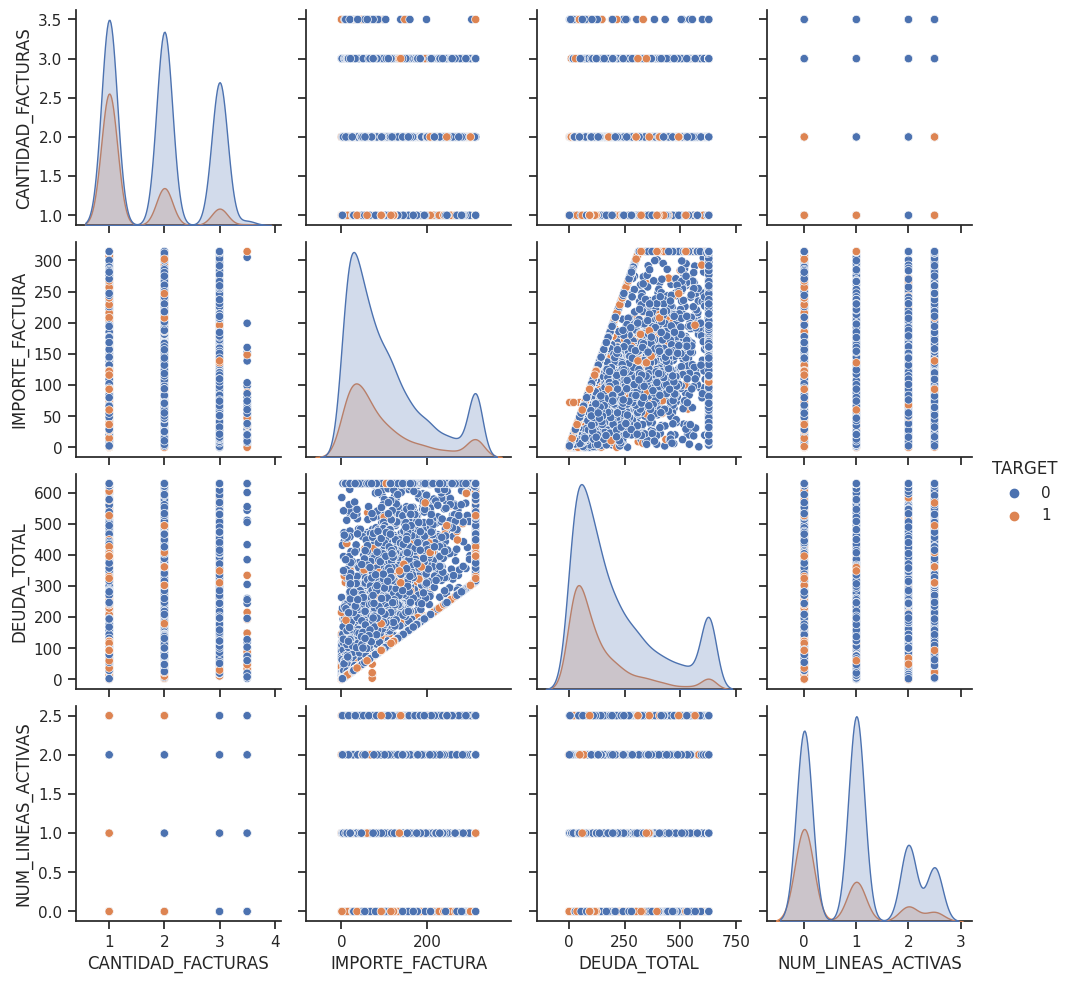

In [62]:
# GRAFICA DE CORRELACION LINEAL ENTRE LAS VARIABLES NUMERICAS

sns.set_theme(style="ticks")

# df = sns.load_dataset("penguins")

lista_numericas = ["CANTIDAD_FACTURAS", "IMPORTE_FACTURA", "DEUDA_TOTAL", "NUM_LINEAS_ACTIVAS", 'TARGET']

sns.pairplot(df3[lista_numericas], hue='TARGET')

<ipython-input-63-9369bc1abeff>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df2.corr(), annot=True, cmap="icefire")


<Axes: >

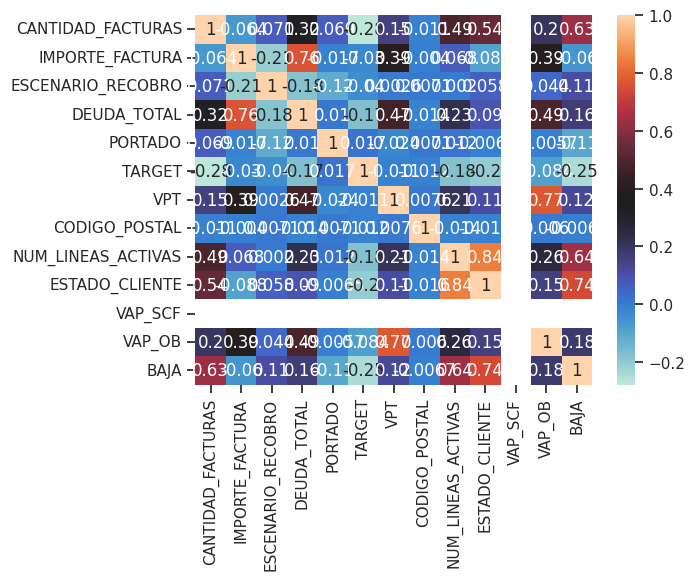

In [63]:
sns.heatmap(df2.corr(), annot=True, cmap="icefire")

<ipython-input-64-34cb5229cc4a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df2.corr(), annot=False, cmap="icefire")


<Axes: >

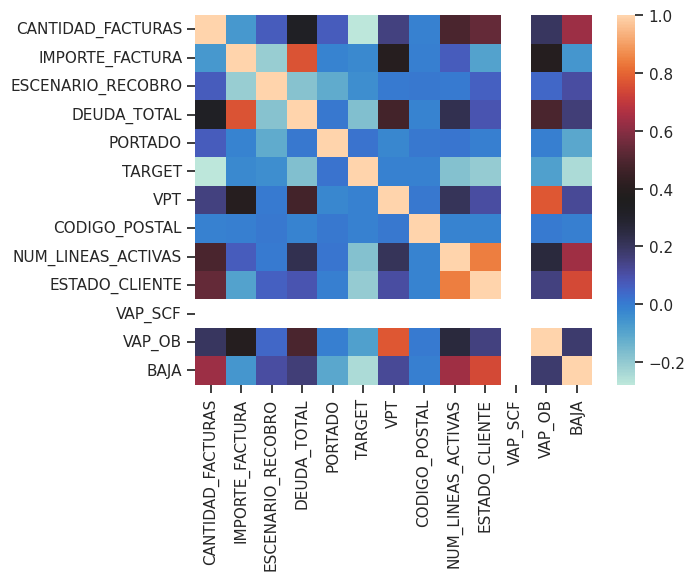

In [64]:
sns.heatmap(df2.corr(), annot=False, cmap="icefire")

In [65]:
# SEPARACION DE X Y
df3_X = df3.drop("TARGET", axis=1)
df3_y = df3["TARGET"]

In [66]:
# ESCALADO DE VARIABLES NUMERICAS
modelo_sc = MinMaxScaler()

df3_X_escalado = modelo_sc.fit_transform(df3_X)

df4_X = pd.DataFrame(df3_X_escalado, columns=df3_X.columns)

df4_X.sample(5)

,CANTIDAD_FACTURAS,IMPORTE_FACTURA,ESCENARIO_RECOBRO,DEUDA_TOTAL,PORTADO,VPT,CODIGO_POSTAL,NUM_LINEAS_ACTIVAS,ESTADO_CLIENTE,VAP_SCF,VAP_OB,BAJA,0_30,31_50,51_65,MAYOR_65
2592,0.0,1.000000,0.0,1.000000,0.0,1.0,0.529412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1141,0.8,0.234120,1.0,0.179572,0.0,0.0,0.529412,0.4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4748,0.0,1.000000,1.0,0.806498,0.0,1.0,0.176471,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1199,0.8,0.063646,1.0,0.858785,0.0,1.0,0.137255,0.4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4629,0.0,0.574147,1.0,0.286914,0.0,1.0,0.529412,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Counter({0: 5455, 1: 1884})


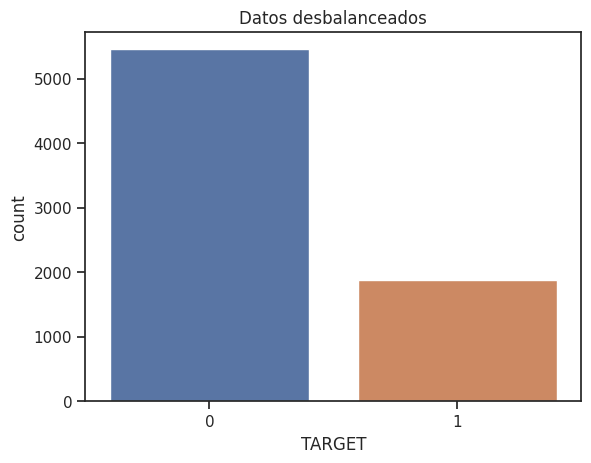

In [67]:
# OBSERVACIONES POR CATEFORIA EN LA VARIABLE TARGET
sns.countplot(x='TARGET', data=pd.DataFrame(df3_y))

plt.title("Datos desbalanceados");

# DATOS TOTALES SIN BALANCEAR
print(Counter(df3_y))

Como podemos ver la cantidad de observaciones de las dos categorías es bastante diferente, si hacemos el modelo con estas cantidades posiblemente obtendremos buena Exactitud ya que el modelo clasifica bien los registros de forma global, pero observando detenidamente nos daremos cuenta que el modelo está clasificando de buena forma la clase mayoritaria mientras que la clase minoritaria sería clasificada pobremente.
Para evitar este problema debemos usar un método que balancee las clases o que aplique una penalización sobre las mismas. Para nuestro caso balanceamos la variable usando el método SMOTE (Synthetic Minority Over-sample Tecnique) que nos permitirá crear registros sintéticos para la clase minoritaria.

In [68]:
# BALANCE DE VARIABLE TARGET (OVERSAMPLING)
oversample = SMOTE()      # SMOTE(sampling_strategy=0.1)
X_bal, y_bal = oversample.fit_resample(df4_X, df3_y)

Counter({0: 5455, 1: 5455})


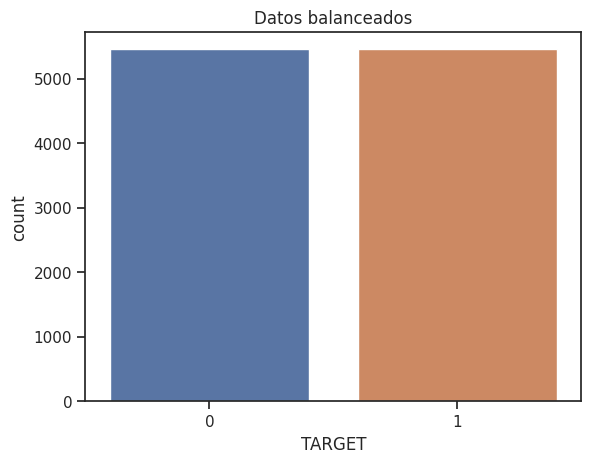

In [69]:
# OBSERVACIONES POR CATEFORIA EN LA VARIABLE TARGET DESPUES DEL BALANCE
sns.countplot(x='TARGET', data=pd.DataFrame(y_bal))

plt.title("Datos balanceados");

# DATOS TOTALES SIN BALANCEAR
print(Counter(y_bal))

In [70]:
# EJEMPLO DE LOS DATOS
X_bal.sample(10)

,CANTIDAD_FACTURAS,IMPORTE_FACTURA,ESCENARIO_RECOBRO,DEUDA_TOTAL,PORTADO,VPT,CODIGO_POSTAL,NUM_LINEAS_ACTIVAS,ESTADO_CLIENTE,VAP_SCF,VAP_OB,BAJA,0_30,31_50,51_65,MAYOR_65
5012,0.000000,1.000000,0.0,0.961389,0.0,1.0,0.058824,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8950,0.000000,0.079630,1.0,0.039793,0.0,1.0,0.137255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5319,0.000000,0.106384,1.0,0.053162,0.0,0.0,0.000000,0.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.800000,0.172511,0.0,0.309607,0.0,0.0,0.549020,0.8,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3318,0.400000,0.292897,1.0,0.537586,0.0,1.0,0.294118,0.4,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
7766,0.166915,0.106981,0.0,0.063415,0.0,0.0,0.620818,0.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2753,0.400000,0.022117,1.0,0.022105,1.0,0.0,0.313725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1983,0.400000,0.260374,1.0,0.241337,0.0,0.0,0.588235,0.4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8940,0.513141,0.436588,1.0,0.520171,0.0,1.0,0.446613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10055,0.000000,0.232291,1.0,0.116081,0.0,0.0,0.784314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [71]:
X_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10910 entries, 0 to 10909
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CANTIDAD_FACTURAS   10910 non-null  float64
 1   IMPORTE_FACTURA     10910 non-null  float64
 2   ESCENARIO_RECOBRO   10910 non-null  float64
 3   DEUDA_TOTAL         10910 non-null  float64
 4   PORTADO             10910 non-null  float64
 5   VPT                 10910 non-null  float64
 6   CODIGO_POSTAL       10910 non-null  float64
 7   NUM_LINEAS_ACTIVAS  10910 non-null  float64
 8   ESTADO_CLIENTE      10910 non-null  float64
 9   VAP_SCF             10910 non-null  float64
 10  VAP_OB              10910 non-null  float64
 11  BAJA                10910 non-null  float64
 12  0_30                10910 non-null  float64
 13  31_50               10910 non-null  float64
 14  51_65               10910 non-null  float64
 15  MAYOR_65            10910 non-null  float64
dtypes: f

In [72]:
# DIVISION DE LA MUESTRA EN DATASET DE ENTRENAMIENTO Y PRUEBA (80%, 20%)
X_ent, X_pru, y_ent, y_pru = train_test_split(X_bal,
                                              y_bal,
                                              test_size=0.2,
                                              random_state=1)

In [73]:
print(X_ent.shape, X_pru.shape, y_ent.shape, y_pru.shape)

(8728, 16) (2182, 16) (8728,) (2182,)


In [74]:
y_ent.info()

<class 'pandas.core.series.Series'>
Int64Index: 8728 entries, 8464 to 235
Series name: TARGET
Non-Null Count  Dtype
--------------  -----
8728 non-null   int64
dtypes: int64(1)
memory usage: 136.4 KB


In [75]:
y_pru.info()

<class 'pandas.core.series.Series'>
Int64Index: 2182 entries, 9222 to 1652
Series name: TARGET
Non-Null Count  Dtype
--------------  -----
2182 non-null   int64
dtypes: int64(1)
memory usage: 34.1 KB


In [76]:
#NUMERO DE VARIABLES
nvars = X_ent.shape[1]
nvars

16

In [77]:
# RANDOM FOREST

modelo_base = RandomForestClassifier(criterion='gini', n_estimators=500, max_depth=10, random_state=123)

modelo_base.fit(X_ent, y_ent)

#y_pred = modelo_base.predict(X_pru)

print("Entrenamiento: {:.1f}".format(100*modelo_base.score(X_ent, y_ent)))

print("Prueba: {:.1f}".format(100*modelo_base.score(X_pru, y_pru)))


Entrenamiento: 79.4
Prueba: 74.2


In [93]:
# ENTRENAMIENTO DEL MODELO Y SELECCION DE HIPERPARAMETROS
!pip install -q -U keras-tuner
import keras_tuner
from keras.optimizers import Adam

In [82]:
tuner = keras_tuner.RandomSearch(
                     model_builder,
                     objective='val_accuracy',
                     directory='runs',
                     project_name='keras_tuner',
                     overwrite=True)

tuner.search_space_summary()

Search space summary
Default search space size: 4
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 9, 'max_value': 27, 'step': 3, 'sampling': 'linear'}
dense_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dense_3_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': (0.01, 0.001, 0.0001, 1e-05), 'ordered': True}


In [83]:
tuner.search(X_ent, y_ent, epochs=50, validation_split=.2, verbose=True)

Trial 10 Complete [00h 00m 42s]
val_accuracy: 0.7130584120750427

Best val_accuracy So Far: 0.7342497110366821
Total elapsed time: 00h 10m 00s


In [84]:
# OBTENEMOS EL MEJOR MODELO
best_model = tuner.get_best_models()[0]

In [85]:
best_model

In [86]:
# OBTENEMOS LOS MEJORES HIPERPARAMETROS ARROJADOS POR LA BUSQUEDA
best_hyperparameters = tuner.get_best_hyperparameters()[0]

In [87]:
best_hyperparameters.get("learning_rate")

0.001

In [88]:
# CONSTRUIMOS UN MODELO CON LOS MEJORES HIPERPARAMETROS
model = tuner.hypermodel.build(best_hyperparameters)

# ENTRENAMOS EL MODELO CON LOS MEJORES HIPERPARAMETROS POR 50 EPOCHS Y VALIDACION DEL 20%

history = model.fit(X_ent,y_ent, epochs=50, validation_split=.2, batch_size=32)

Epoch 1/50
219/219 [==============================] - 2s 6ms/step - loss: 0.6347 - accuracy: 0.6452 - val_loss: 0.5973 - val_accuracy: 0.6833
Epoch 2/50
219/219 [==============================] - 1s 5ms/step - loss: 0.6107 - accuracy: 0.6700 - val_loss: 0.5935 - val_accuracy: 0.6970
Epoch 3/50
219/219 [==============================] - 1s 5ms/step - loss: 0.6022 - accuracy: 0.6783 - val_loss: 0.5894 - val_accuracy: 0.7033
Epoch 4/50
219/219 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.6825 - val_loss: 0.5804 - val_accuracy: 0.7090
Epoch 5/50
219/219 [==============================] - 1s 6ms/step - loss: 0.5935 - accuracy: 0.6860 - val_loss: 0.5812 - val_accuracy: 0.7079
Epoch 6/50
219/219 [==============================] - 2s 7ms/step - loss: 0.5887 - accuracy: 0.6868 - val_loss: 0.5828 - val_accuracy: 0.7010
Epoch 7/50
219/219 [==============================] - 2s 7ms/step - loss: 0.5857 - accuracy: 0.6935 - val_loss: 0.5798 - val_accuracy: 0.7062
Epoch 

In [89]:
# EXTRAIGAMOS EL NUMERO OPTIMO DE ITERACIONES A ENTRENAR EL MODELO
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
print(f'Número óptimo de epochs: {best_epoch}')

Número óptimo de epochs: 47


In [90]:
# ENTRENEMOS UN MODELO CON LOS MEJORES HIPERPARAMETROS Y EL MEJOR NUMERO DE EPOCHS
best_model = tuner.hypermodel.build(best_hyperparameters)
best_model.fit(X_ent, y_ent, epochs=best_epoch, validation_split=.2, batch_size=32)

Epoch 1/47
219/219 [==============================] - 2s 5ms/step - loss: 0.6387 - accuracy: 0.6442 - val_loss: 0.6015 - val_accuracy: 0.6873
Epoch 2/47
219/219 [==============================] - 1s 5ms/step - loss: 0.6129 - accuracy: 0.6691 - val_loss: 0.6002 - val_accuracy: 0.6896
Epoch 3/47
219/219 [==============================] - 2s 7ms/step - loss: 0.6036 - accuracy: 0.6776 - val_loss: 0.5950 - val_accuracy: 0.6919
Epoch 4/47
219/219 [==============================] - 2s 8ms/step - loss: 0.5971 - accuracy: 0.6822 - val_loss: 0.5859 - val_accuracy: 0.7027
Epoch 5/47
219/219 [==============================] - 2s 7ms/step - loss: 0.5928 - accuracy: 0.6846 - val_loss: 0.5795 - val_accuracy: 0.7090
Epoch 6/47
219/219 [==============================] - 1s 5ms/step - loss: 0.5896 - accuracy: 0.6901 - val_loss: 0.5774 - val_accuracy: 0.7108
Epoch 7/47
219/219 [==============================] - 1s 5ms/step - loss: 0.5839 - accuracy: 0.6918 - val_loss: 0.5728 - val_accuracy: 0.6993
Epoch 

In [91]:
# EVALUEMOS EL MODELO SOBRE LOS DATOS DE PRUEBAS
result = best_model.evaluate(X_pru, y_pru, verbose=0)
print(f'Pérdida de prueba: {result[0]}')
print(f'Exactitud de prueba: {result[1] * 100:.2f}%')

Pérdida de prueba: 0.601169228553772
Exactitud de prueba: 69.62%


In [92]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 24)                408       
                                                                 
 dense_9 (Dense)             (None, 384)               9600      
                                                                 
 dense_10 (Dense)            (None, 384)               147840    
                                                                 
 dense_11 (Dense)            (None, 1)                 385       
                                                                 
Total params: 158,233
Trainable params: 158,233
Non-trainable params: 0
_________________________________________________________________
